# Drip Line Pressure and Flow Estimator

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Functions as fun
import seaborn as sns
sns.set_context("paper",font_scale=2)

Let's get the lines from previous notebook:

In [2]:
lines = fun.import_lines()
main_line = fun.import_main_line()

In [3]:
pd.DataFrame(lines, columns=['x1','y1','x2','y2']).head()

,x1,y1,x2,y2
0,259912.219300,794407.317100,259977.921100,794417.510300
1,259913.139156,794401.388031,259978.840956,794411.581231
2,259914.059012,794395.458961,259979.760812,794405.652161
3,259914.978868,794389.529892,259980.680668,794399.723092
4,259915.898724,794383.600822,259981.600524,794393.794022


In [4]:
main_line

array([[259912.2193    , 794407.3171    ],
       [259938.89512233, 794235.37408472],
       [259906.01353769, 794163.48315452],
       [259908.77310552, 794145.69594605]])

Let's plot everything:

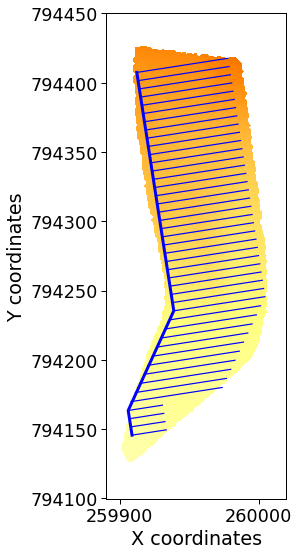

In [5]:
fun.plot_map(False, False) # Plotting map
plt.grid(b=False)

for line in lines: # Plotting drip lines
    line = line.reshape(2,2)
    plt.plot(line[:,0],line[:,1],c='blue')

plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3) # Plotting main line

The drip line we chose is with the following attributes:

TifDrip (no pressure compensating) 16/1(1.0 mm)
* L = 66 m
* Drip space = 0.4 m $\rightarrow$ 66/0.4 = 165 emitters.
* D = 0.016 m
* $q_\text{nom} = 1.5 \frac{l}{h} = 4.167 \times 10^{-7}$ m$^3$/s
* $C = 140$ (Assuming that the material is polyethylen and according to [this](https://www.engineeringtoolbox.com/hazen-williams-coefficients-d_798.html]))

With the following Flow-Pressure charchteristic:

$\displaystyle F = a\times P^{x}$

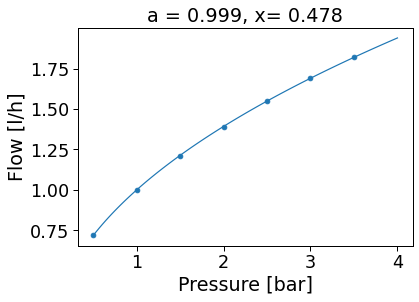

In [6]:
P = np.arange(0.5,4,0.5) # From Naan Catalog [bar]
F = np.array([0.72,1,1.21,1.39,1.55,1.69,1.82]) # From Naan Catalog [l/h]
plt.scatter(P,F)

def drip_flow_obj(parameters):
    a,x = parameters # a constant, x exponent
    return np.sum((a * P ** x - F)**2)

from scipy.optimize import minimize
a,x = minimize(drip_flow_obj, (0.5,0.5)).x

pressures = np.linspace(0.5,4,100)


plt.plot(pressures, a * pressures ** x)
plt.title('a = {:.3f}, x= {:.3f}'.format(a,x))
plt.xlabel('Pressure [bar]')
plt.ylabel('Flow [l/h]')
plt.savefig('Figures/DripFlowPressure1',bbox_inches='tight')

Let's create a function that get the pressure in head [m] and gives the flow in [m$^3$/s] according to:

* $\displaystyle P[bar] = 10^{-5} P [\text{Pa}]= \frac{9800}{10^5} Pa[\text{m}]$

* $\displaystyle F\left[\frac{\text{m}^3}{s}\right] = F\left[\frac{l}{s}\right] / (1000 \times 3600) $

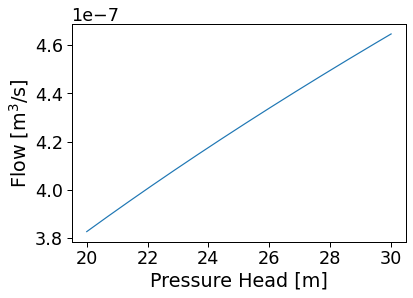

In [7]:
def drip_flow(pressure): # Getting the pressure in [m]
    a = 0.999
    x = 0.478
    pressure = pressure * (9800/1e5) # [bar]
    flow = a * pressure ** x # [l/h]
    return flow / (1000 * 3600) # [m^3/s]

P = np.linspace(20,30,1000)
plt.plot(P,drip_flow(P))
plt.xlabel('Pressure Head [m]')
plt.ylabel(r'Flow [m$^3$/s]')
plt.savefig('Figures/DripFlowPressure2',bbox_inches='tight')

The goal now is to calculate the pressure and flow for the first drip line. It's resemble a boundary values problem where we know the terminal state but not the initial. So the approach is to start from the end:

* Let's assume that we know the pressure of the last emitter in the drip line which is called $P_N$.
* From that we can calculate $q_N$
* We will add to it the $Q_\text{total line}$
* Calculate the section head loss according to $hf = L\left(\frac{Q_\text{total line}}{C}\right)^\alpha\frac{10.67}{D^\beta}$
* Calculating the pressure at the next emitter $P_{N-1} = P_{N} + hf + Z_N - Z_{N-1}$

And so on until we get to emitter N=1, which is the first one after the main line. Afterward we only calculate the pressure at the line $P_0$ and checking if it matches to the initial value. If not we repeat this whole procedure with better guess of $P_N$

### Application

Let's assume that the initial pressure the last emitter pressure head is $P_N/\gamma = 25$ m.

Let's plot the drip line profile:

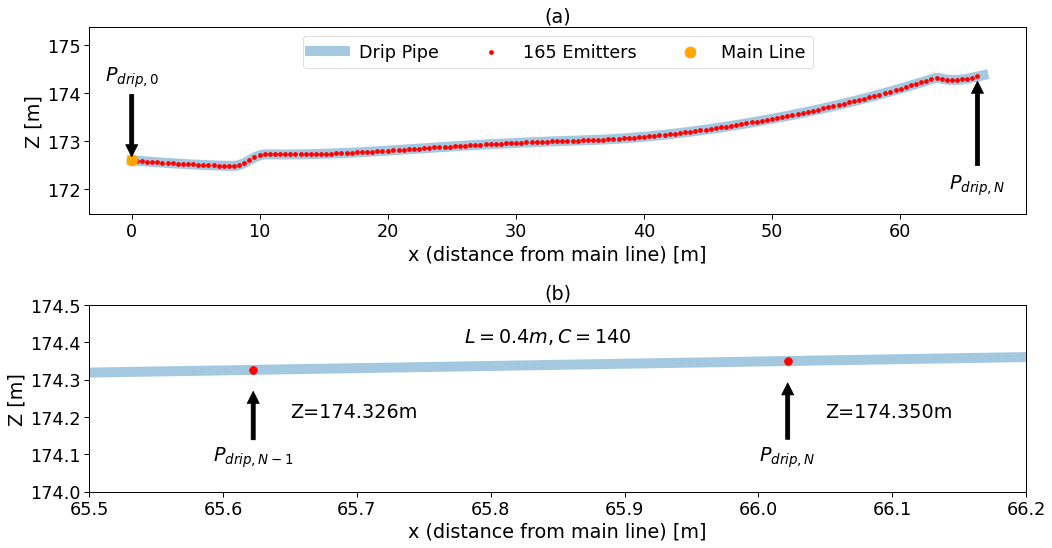

In [21]:
profile = fun.get_profile(lines[0].reshape(2,2),1000)
x = profile[:,0].flatten()
zx = profile[:,1].flatten()

# Adding the closest location of the emitter
x_emitters = np.arange(0.4,66.4,0.4)
i = []
for e in x_emitters:
     i.append(np.argmin(np.absolute(e - x.flatten())))
x_emitters = x[i]
z_emitters = zx[i]

x_main_line = x[0]
z_main_line = zx[0]

fig, axes = plt.subplots(2,1,figsize=(15,8),tight_layout={'h_pad':3})
for axis in axes:
    axis.plot(x, zx,lw=10,alpha=0.4, label='Drip Pipe',zorder=0)
    axis.set_xlabel('x (distance from main line) [m]')
    axis.set_ylabel('Z [m]')
    axis.scatter(x_emitters,z_emitters, s=15,
                 c='red',label='{} Emitters'.format(len(x_emitters)),zorder=1 )
    axis.scatter(x_main_line,z_main_line, s=120, c='orange',label='Main Line',zorder=1)

axes[1].scatter(x_emitters,z_emitters, s=60, c='red',label='{} Emitters'.format(len(x_emitters)))
axes[1].set_xlim(65.5,66.2)
axes[1].set_ylim(174,174.5)
axes[0].set_ylim(min(zx)-1,max(zx) + 1)
axes[0].legend(loc=9,ncol=3)

axes[0].set_title('(a)')
axes[1].set_title('(b)')

# Annotations
def arrow(axis,text,xy_data,xy_text):
    axis.annotate(text, xy=xy_data,  xycoords='data',
                xytext=xy_text,
                arrowprops=dict(facecolor='black', shrink=0.05),
                 horizontalalignment='center', verticalalignment='top')
arrow(axes[0],r'$P_{drip,0}$',(x_main_line,z_main_line),(x_main_line,z_main_line+2))
arrow(axes[0],r'$P_{drip,N}$',(x_emitters[-1],z_emitters[-1]),(x_emitters[-1],z_emitters[-1]-2))
arrow(axes[1],r'$P_{drip,N-1}$',(x_emitters[-2],z_emitters[-2]-0.05),(x_emitters[-2],z_emitters[-2]-0.2))
arrow(axes[1],r'$P_{drip,N}$',(x_emitters[-1],z_emitters[-1]-0.05),(x_emitters[-1],z_emitters[-2]-0.2))
axes[1].text(65.78,174.4,r'$L=0.4m, C=140$')
axes[1].text(66.05,174.2,'Z={:.3f}m'.format(z_emitters[-1]))
axes[1].text(65.65,174.2,'Z={:.3f}m'.format(z_emitters[-2]))
plt.savefig('Figures/DripFlowPressure3',bbox_inches='tight')

Let's calculate the drip line pressure with initial guess of $P_N/\gamma = 25$ m while we aiming to $P_0/\gamma = 27$ m

4.008350008998631e-07
1.4476255689826316e-06
3.0686793265515045e-06
5.229825355137614e-06
7.908278363275248e-06
1.1086807461772714e-05
1.4751358624750393e-05
1.888983712618527e-05
2.3492569406154495e-05
2.8555366215353873e-05
3.4072646632982127e-05
4.003889842452978e-05
4.6449181347398675e-05
5.32990425164146e-05
6.0584436489374174e-05
6.83016627991809e-05
7.644731625606894e-05
8.501907620324198e-05
9.401324895675019e-05
0.00010342709911813315
0.00011325806372589497
0.00012350373302766915
0.0001341618341134605
0.00014523021688111473
0.0001567068419211283
0.0001685897699947687
0.00018087715284537774
0.00019356722513331885
0.00020665829732433776
0.00022014874939188213
0.00023403702521831955
0.00024832162759944916
0.00026300111377236594
0.00027807409139942536
0.0002935392149514176
0.0003093951824415828
0.0003256407324691263
0.00034227464153673514
0.0003592957216115239
0.0003767028179028919
0.0003944948068342801
0.00041267059418874374
0.00043122911341075544
0.0004501693240487999
0.00046949

Text(0.5, 0.98, 'The main line pressure is 27.06 m, The drip line whole flow is 719.60 m$^3$/s e-7')

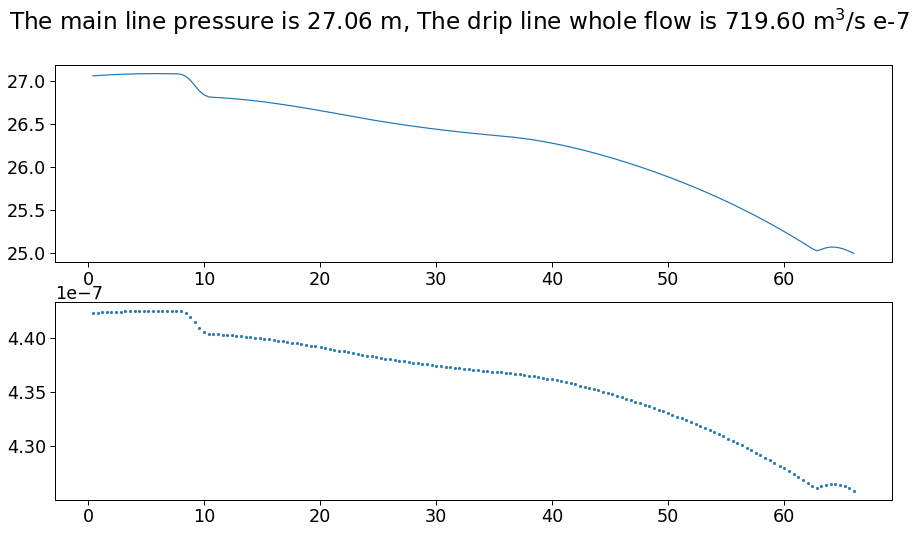

In [9]:
class DripLineEstimator():
    def __init__(self, L_space=0.4, D=0.016, C=140):
        self.L_space = L_space
        self.D = D # [m]
        self.C = C
        self.alpha = 1.852
        self.beta = 4.87        
    def estimate(self, P_terminal_guess, x_main_line, x_emitters, z_main_line, z_emitters):
        self.x_points = np.append(x_main_line,x_emitters)
        self.z_points = np.append(z_main_line,z_emitters)
        
        self.P_line = np.array([P_terminal_guess])
        self.Q_line = np.array([])
        
        for i in np.arange(-1,-len(self.x_points),-1):
            z = self.z_points[i]
            z_pre = self.z_points[i-1] # The altitude of emitter N-1
            q = drip_flow(self.P_line[-1])
            self.Q_line = np.append(self.Q_line, q)
            hf = self.L_space * ((np.sum(self.Q_line) / self.C) ** self.alpha) * (10.67 / (self.D ** self.beta))
            print(hf)
            self.P_line = np.append(self.P_line, hf + self.P_line[-1] + z - z_pre)
            
        # Reversing the order
        self.P_line = self.P_line[::-1]
        self.Q_line = self.Q_line[::-1]
        
        # Seperating the main line pressure from the drip line
        self.P_main_line = self.P_line[0]
        self.P_line = self.P_line[1:]
        
        return self.P_line, self.Q_line, self.P_main_line


est = DripLineEstimator()
P_line,Q_line,P_main_line = est.estimate(25,
                                         x_main_line,
                                         x_emitters,
                                         z_main_line,
                                         z_emitters)


fig, axes = plt.subplots(2,1, figsize=(15,8)) 
axes[0].plot(x_emitters,P_line)
axes[1].scatter(x_emitters,Q_line,s=5)
 
title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'
fig.suptitle(title.format(P_main_line, (np.sum(Q_line)*1e7)))

Now let's try to get the right $P_0 = 27$ m.

In [10]:
from scipy.optimize import fsolve

def f(variable):
    P_terminal_guess = variable[0]
    est = DripLineEstimator()
    _,_,P_main_line = est.estimate(P_terminal_guess,
                                   x_main_line,
                                   x_emitters,
                                   z_main_line,
                                   z_emitters)
    return P_main_line - 27
P_terminal_value = fsolve(f,np.array([25]))[0] # Initial guess of 25
P_terminal_value

4.008350008998631e-07
1.4476255689826316e-06
3.0686793265515045e-06
5.229825355137614e-06
7.908278363275248e-06
1.1086807461772714e-05
1.4751358624750393e-05
1.888983712618527e-05
2.3492569406154495e-05
2.8555366215353873e-05
3.4072646632982127e-05
4.003889842452978e-05
4.6449181347398675e-05
5.32990425164146e-05
6.0584436489374174e-05
6.83016627991809e-05
7.644731625606894e-05
8.501907620324198e-05
9.401324895675019e-05
0.00010342709911813315
0.00011325806372589497
0.00012350373302766915
0.0001341618341134605
0.00014523021688111473
0.0001567068419211283
0.0001685897699947687
0.00018087715284537774
0.00019356722513331885
0.00020665829732433776
0.00022014874939188213
0.00023403702521831955
0.00024832162759944916
0.00026300111377236594
0.00027807409139942536
0.0002935392149514176
0.0003093951824415828
0.0003256407324691263
0.00034227464153673514
0.0003592957216115239
0.0003767028179028919
0.0003944948068342801
0.00041267059418874374
0.00043122911341075544
0.0004501693240487999
0.00046949

0.0021284515597324934
0.0021680787584276396
0.002208048240119849
0.002248359805943291
0.002289013268090346
0.0023300084497517117
0.0023713451850596564
0.002413023319034281
0.0024550427075326698
0.0024974031673310926
0.0025401044037153516
0.0025831461095124687
0.002626527968669436
0.00267024965572148
0.0027143108352644055
0.0027587111614308093
0.0028034511563709156
0.0028485295600502018
0.0028939459893797263
0.002939700048688425
0.002985791329216494
0.003032219408611744
0.0030789838504287443
0.003126084203630654
0.0031735200020935584
0.0032212907641132214
0.003269395991914091
0.0033178351711604156
0.0033666077704693717
0.003415713240926035
0.003465151015600099
0.0035149205090641918
0.003565021116913687
0.0036154522152878274
0.0036662131603921303
0.0037173032880218632
0.0037687219130865027
0.0038204683291350587
0.0038725418078821195
0.00392494369408773
0.0039776927385398175
0.004030808956430434
0.004084308988787377
0.004138193658643574
0.004192446618732563
0.004247047110933492
0.00430197

24.941996035343813

Let's try it:

4.000116024547718e-07
1.4446532605840879e-06
3.0623814765170567e-06
5.219096347531959e-06
7.892059451606532e-06
1.106407455758238e-05
1.4721114904126683e-05
1.885110806311566e-05
2.344439950939592e-05
2.8496817573968947e-05
3.4002796284589424e-05
3.995683657832828e-05
4.6354010076926696e-05
5.318987468027676e-05
6.0460394822751784e-05
6.816187913906818e-05
7.629093087310377e-05
8.484523743202755e-05
9.382111227618075e-05
0.00010321582689479445
0.00011302682481109793
0.0001232517023962392
0.00013388819253818822
0.00014493415063789378
0.00015638754252068538
0.0001682464339375807
0.00018050898139692536
0.0001931734241172709
0.00020623807693162332
0.0002197013240039029
0.0002335616132428014
0.0002478174513176348
0.00026246739919642196
0.00027751006813907887
0.0002929441160889611
0.00030876824441448817
0.0003249811949595964
0.00034158174736760073
0.00035856871664795493
0.0003759409509594519
0.000393697329586902
0.0004118367610912449
0.00043035818161555407
0.0004492605533315198
0.00046854286

Text(0.5, 0.98, 'The main line pressure is 27.00 m, The drip line whole flow is 718.84 m$^3$/s e-7')

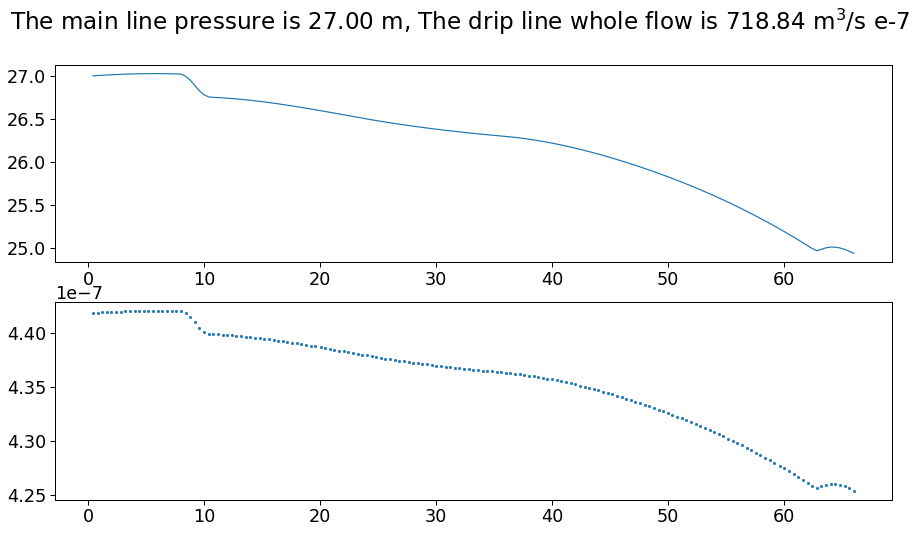

In [11]:
est = DripLineEstimator()
P_line,Q_line,P_main_line = est.estimate(P_terminal_value,
                                                     x_main_line,
                                                     x_emitters,
                                                     z_main_line,
                                                     z_emitters)


fig, axes = plt.subplots(2,1, figsize=(15,8)) 
axes[0].plot(x_emitters,P_line)
axes[1].scatter(x_emitters,Q_line,s=5)
 
title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'
fig.suptitle(title.format(P_main_line, (np.sum(Q_line)*1e7)))

Perfect, we will pack everything inside Function.py.

Text(0.5, 0.98, 'The main line pressure is 27.00 m, The drip line whole flow is 718.84 m$^3$/s e-7')

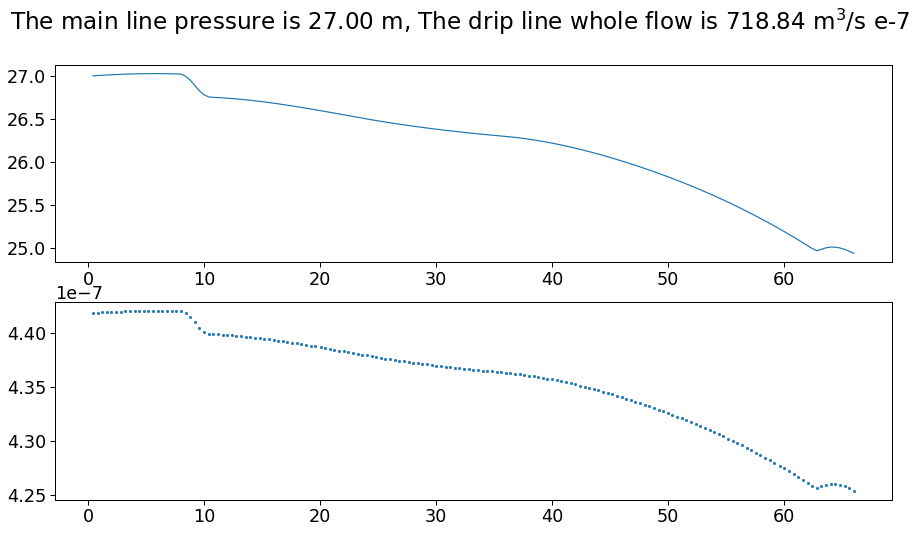

In [12]:
# Checking if the estimator in Function.py is working

est = fun.DripLineEstimator()

'''
The arguments are:
    1) The main line pressure
    2) x_main_line - the distance of main line from main line - 0 all the time
    3) x_emitters - the distance of all emitter from main line
    4) z_main_line - the altitude of main line connection point to the drip line
    5) z_emitters - the altitude of all emitters.
'''
P_line,Q_line,P_main_line = est.estimate(27, x_main_line, x_emitters, z_main_line, z_emitters)

fig, axes = plt.subplots(2,1, figsize=(15,8)) 
axes[0].plot(x_emitters,P_line)
axes[1].scatter(x_emitters,Q_line,s=5)
 
title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'
fig.suptitle(title.format(P_main_line, (np.sum(Q_line)*1e7)))

# NOTE

For the next notebooks, we save all of the necessary functions in Functions.py so we won't have to write all of the code one again.